In [1]:
# Êï∞ÂÄ§Ë®àÁÆó„Å´‰Ωø„ÅÜ„É©„Ç§„Éñ„É©„É™
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize

# Áµ±Ë®à„É¢„Éá„É´„ÇíÊé®ÂÆö„Åô„Çã„É©„Ç§„Éñ„É©„É™
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# „Ç∞„É©„Éï„ÇíÊèèÁîª„Åô„Çã„É©„Ç§„Éñ„É©„É™
from matplotlib import pylab as plt
import seaborn as sns

sns.set()

In [13]:
# Ë°®Á§∫Ë®≠ÂÆö
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["figure.figsize"] = 8, 4

In [3]:
# ‰π±Êï∞„ÅÆÁ®Æ
np.random.seed(1)

# Ê≠£Ë¶èÂàÜÂ∏É„Å´Âæì„ÅÜ‰π±Êï∞„ÅÆÁ¥ØÁ©çÂíå„Çí‰ΩúÊàê„Åó„ÄÅ„É©„É≥„ÉÄ„É†„Ç¶„Ç©„Éº„ÇØÁ≥ªÂàó„Çí‰Ωú„Çã
sim_size = 100
mu = np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size).round(1)) + 30

# Ë¶≥Ê∏¨ÂÄ§„ÅÆ‰ΩúÊàê
y = mu + stats.norm.rvs(loc=0, scale=5, size=sim_size).round(1)

# ÊôÇÁ≥ªÂàó„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„ÅÆ‰ªò‰∏é
y_ts = pd.Series(y, index=pd.date_range(start="2020-01-01", periods=sim_size, freq="D"))

In [4]:
class LocalLevel:
    # „Éá„Éº„Çø„ÇíÊ†ºÁ¥ç(pd.Series„Åß„ÄÅÊó•‰ªò„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„Åå„Å§„ÅÑ„Å¶„ÅÑ„ÇãÊÉ≥ÂÆö)
    def __init__(self, ts_data):
        self.ts_data = ts_data
        self.a = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.P = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.v = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.F = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.K = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.s_level = None  # ÈÅéÁ®ãË™§Â∑Æ„ÅÆÂàÜÊï£
        self.s_irregular = None  # Ë¶≥Ê∏¨Ë™§Â∑Æ„ÅÆÂàÜÊï£

    # Áä∂ÊÖã„ÅÆÂàùÊúüÂÄ§„ÇíË®≠ÂÆö„Åô„Çã
    def initialize(self, initial_a, initial_P):
        self.initial_a = initial_a
        self.initial_P = initial_P

    # 1ÊôÇÁÇπÂÖà„ÅÆ‰∫àÊ∏¨ÂÄ§„ÇíË®àÁÆó„Åô„Çã
    def _forecast_step(self, a_pre, P_pre, s_irregular, s_level, first=False):
        if first:
            a_forecast = self.initial_a  # ÂàùÂõû„Å´Èôê„Çä„ÄÅÂàùÊúüÂÄ§„Çí‰ª£ÂÖ•
            P_forecast = self.initial_P  # ÂàùÂõû„Å´Èôê„Çä„ÄÅÂàùÊúüÂÄ§„Çí‰ª£ÂÖ•
        else:
            a_forecast = a_pre  # Áä∂ÊÖã„ÅÆ‰∫àÊ∏¨ÂÄ§
            P_forecast = P_pre + s_level  # Áä∂ÊÖã„ÅÆ‰∫àÊ∏¨ÂÄ§„ÅÆÂàÜÊï£

        y_forecast = a_forecast  # Ë¶≥Ê∏¨ÂÄ§„ÅÆ‰∫àÊ∏¨ÂÄ§
        F = P_forecast + s_irregular  # Ë¶≥Ê∏¨ÂÄ§„ÅÆ‰∫àÊ∏¨ÂÄ§„ÅÆÊÆãÂ∑Æ„ÅÆÂàÜÊï£

        return pd.Series(
            [a_forecast, P_forecast, y_forecast, F], index=["a", "P", "y", "F"]
        )

    # 1ÊôÇÁÇπ„ÅÆ„Éï„Ç£„É´„Çø„É™„É≥„Ç∞„Çí„Åô„Çã
    def _filter_step(self, forecasted, y, s_irregular):
        v = y - forecasted.y  # Ë¶≥Ê∏¨ÂÄ§„ÅÆ1ÊôÇÁÇπÂÖà‰∫àÊ∏¨ÂÄ§„ÅÆÊÆãÂ∑Æ
        K = forecasted.P / forecasted.F  # „Ç´„É´„Éû„É≥„Ç≤„Ç§„É≥
        a_filter = forecasted.a + K * v  # „Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÈáèÔºàÊõ¥Êñ∞Âæå„ÅÆÁä∂ÊÖãÊé®ÂÆöÂÄ§Ôºâ
        P_filter = (1 - K) * forecasted.P  # „Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÈáè„ÅÆÂàÜÊï£ÔºàÊõ¥Êñ∞Âæå„ÅÆ‰∏çÁ¢∫ÂÆüÊÄßÔºâ

        return pd.Series([a_filter, P_filter, v, K], index=["a", "P", "v", "K"])

    # „Éï„Ç£„É´„Çø„É™„É≥„Ç∞„ÇíË°å„ÅÜ
    def filter(self, s_irregular, s_level):
        for i in range(0, len(self.ts_data)):
            if i == 0:
                # ÂàùÂõû„ÅÆ„Åø„ÄÅÂàùÊúüÂÄ§„ÅÆÂÄ§„ÇíÂà©Áî®„Åó„Å¶‰∫àÊ∏¨„Åô„Çã
                forecast_loop = self._forecast_step(
                    a_pre=None,
                    P_pre=None,
                    s_irregular=s_irregular,
                    s_level=s_level,
                    first=True,
                )
            else:
                # 2ÊôÇÁÇπÁõÆ‰ª•Èôç„ÅØ„ÄÅ1ÊôÇÁÇπÂâç„ÅÆÊé®ÂÆöÁµêÊûú„ÇíÂèÇÁÖß„Åó„Å¶‰∫àÊ∏¨„Åô„Çã
                forecast_loop = self._forecast_step(
                    a_pre=self.a.iloc[i - 1],
                    P_pre=self.P.iloc[i - 1],
                    s_irregular=s_irregular,
                    s_level=s_level,
                )

            # „Éï„Ç£„É´„Çø„É™„É≥„Ç∞„ÅÆÂÆüË°åÔºà‰∫àÊ∏¨„Å®Ë¶≥Ê∏¨„ÅÆËûçÂêàÔºâ
            filter_loop = self._filter_step(
                forecasted=forecast_loop,
                y=self.ts_data.iloc[i],
                s_irregular=s_irregular,
            )

            # ÁµêÊûú„ÅÆ‰øùÂ≠ò
            self.a.iloc[i] = filter_loop.a  # Êõ¥Êñ∞Âæå„ÅÆÁä∂ÊÖãÊé®ÂÆöÂÄ§
            self.P.iloc[i] = filter_loop.P  # Êõ¥Êñ∞Âæå„ÅÆÂàÜÊï£
            self.F.iloc[i] = forecast_loop.F  # ÊÆãÂ∑ÆÂàÜÊï£
            self.K.iloc[i] = filter_loop.K  # „Ç´„É´„Éû„É≥„Ç≤„Ç§„É≥
            self.v.iloc[i] = filter_loop.v  # Ë¶≥Ê∏¨Ë™§Â∑ÆÔºàÊÆãÂ∑ÆÔºâ

    # ÂØæÊï∞Â∞§Â∫¶„ÅÆË®àÁÆó
    def llf(self):
        # Ê≠£Ë¶èÂàÜÂ∏É„Çí‰ªÆÂÆö„Åó„ÅüÂ∞§Â∫¶„ÅÆÂØæÊï∞Âíå
        return np.sum(np.log(stats.norm.pdf(x=self.v, loc=0, scale=np.sqrt(self.F))))

    # „Éë„É©„É°„Éº„Çø„ÅÆÊé®ÂÆö„Å®Áä∂ÊÖã„ÅÆÂÜçÂΩì„Å¶„ÅØ„ÇÅ
    def fit(self, start_params):
        # ÂÜÖÈÉ®Èñ¢Êï∞Ôºö„Éë„É©„É°„Éº„Çø„ÇíÊåáÂÆö„Åó„Å¶ÂØæÊï∞Â∞§Â∫¶„ÅÆ-1ÂÄç„ÇíË®àÁÆó
        def calc_llf(params):
            self.filter(
                np.exp(params[0]), np.exp(params[1])
            )  # ÂØæÊï∞„Éë„É©„É°„Éº„Çø„ÇíÊåáÊï∞Â§âÊèõ
            return self.llf() * -1  # ÊúÄÈÅ©Âåñ„Åß„ÅØÊúÄÂ∞èÂåñ„ÇíË°å„ÅÜ„Åü„ÇÅ„ÄÅË≤†„ÅÆÂØæÊï∞Â∞§Â∫¶„ÇíËøî„Åô

        # Nelder-MeadÊ≥ï„Å´„Çà„ÇãÊúÄÈÅ©Âåñ
        opt_res = minimize(
            calc_llf,
            start_params,
            method="Nelder-Mead",
            tol=1e-6,
            options={"maxiter": 2000},
        )

        # Êé®ÂÆö„Åï„Çå„Åü„Éë„É©„É°„Éº„Çø„ÅÆ‰øùÂ≠ò
        self.s_irregular = np.exp(opt_res.x[0])  # Ë¶≥Ê∏¨Ë™§Â∑Æ„ÅÆÂàÜÊï£
        self.s_level = np.exp(opt_res.x[1])  # ÈÅéÁ®ãË™§Â∑Æ„ÅÆÂàÜÊï£

        # ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø„ÅßÂÜçÂ∫¶„Éï„Ç£„É´„Çø„É™„É≥„Ç∞„ÇíÂÆüË°å
        self.filter(self.s_irregular, self.s_level)

    # Êé®ÂÆö„Åï„Çå„ÅüÁä∂ÊÖã„ÅÆÂèØË¶ñÂåñ
    def plot_level(self):
        # Ë¶≥Ê∏¨ÂÄ§„Å®„Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÂÄ§„Çí‰∏¶„Åπ„Å¶„Éó„É≠„ÉÉ„Éà
        plot_df = pd.concat([self.a, self.ts_data], axis=1)
        plot_df.columns = ["filtered", "y"]
        plot_df.plot(title="Áä∂ÊÖãÊé®ÂÆöÂÄ§ÔºàfilteredÔºâ„Å®Ë¶≥Ê∏¨ÂÄ§ÔºàyÔºâ")

In [5]:
# „Éá„Éº„Çø„ÇíÊ†ºÁ¥ç
local_level = LocalLevel(y_ts)
# ‚Üí LocalLevel„ÇØ„É©„Çπ„ÅÆ„Ç§„É≥„Çπ„Çø„É≥„Çπ„Çí‰ΩúÊàê„Åó„ÄÅÂØæË±°„ÅÆÊôÇÁ≥ªÂàó„Éá„Éº„ÇøÔºày_tsÔºâ„ÇíÂÜÖÈÉ®„Å´‰øùÊåÅ„Åô„Çã„ÄÇ

# ÂàùÊúüÂåñ
local_level.initialize(initial_a=0, initial_P=1000000)
# ‚Üí Áä∂ÊÖã„ÅÆÂàùÊúüÂÄ§„ÇíË®≠ÂÆö„Åô„Çã„ÄÇ
#   - initial_a : Áä∂ÊÖãÔºà„É¨„Éô„É´Ôºâ„ÅÆÂàùÊúüÊé®ÂÆöÂÄ§Ôºà„Åì„Åì„Åß„ÅØ0Ôºâ
#   - initial_P : Áä∂ÊÖãÂàÜÊï£ÔºàÂàùÊúü„ÅÆ‰∏çÁ¢∫ÂÆüÊÄß„ÇíÈùûÂ∏∏„Å´Â§ß„Åç„Åè„Åó„Å¶„ÅÑ„ÇãÔºâ

# „Éï„Ç£„É´„Çø„É™„É≥„Ç∞
local_level.filter(s_irregular=10, s_level=1)
# ‚Üí „Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÇíÈÅ©Áî®„Åó„Å¶„ÄÅÂêÑÊôÇÁÇπ„Åß„ÅÆÁä∂ÊÖãÔºà„É¨„Éô„É´Ôºâ„ÇíÊé®ÂÆö„Åô„Çã„ÄÇ
#   - s_irregular : Ë¶≥Ê∏¨Ë™§Â∑Æ„ÅÆÂàÜÊï£ (œÉ_Œµ¬≤)
#   - s_level     : ÈÅéÁ®ãË™§Â∑Æ„ÅÆÂàÜÊï£ (œÉ_Œ∑¬≤)
#
# „Åì„ÅÆÊìç‰Ωú„Å´„Çà„Çä„ÄÅlocal_level.aÔºàÁä∂ÊÖãÊé®ÂÆöÂÄ§Ôºâ„ÇÑ local_level.vÔºàÊÆãÂ∑ÆÔºâ„Å™„Å©„ÅåÊõ¥Êñ∞„Åï„Çå„Çã„ÄÇ
# „Å§„Åæ„Çä„ÄÅ„ÄåË¶≥Ê∏¨ÂÄ§ y_t„Äç„Åã„Çâ„ÄåÁúü„ÅÆ„É¨„Éô„É´ Œº_t„Äç„ÇíÈÄêÊ¨°Êé®ÂÆö„Åô„ÇãÈÅéÁ®ã„Åß„ÅÇ„Çã„ÄÇ

In [6]:
# „Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÈáè„ÇíÂ∞èÊï∞ÁÇπÁ¨¨5‰Ωç„Åæ„Åß‰∏∏„ÇÅ„Å¶‰∏ä‰Ωç3Ë°å„ÇíË°®Á§∫
local_level.a.round(5).head(3)

# ‚ñºË™¨Êòé
# local_level.a „ÅØ„ÄåÂêÑÊôÇÁÇπ„Å´„Åä„Åë„Çã„Éï„Ç£„É´„ÇøÂåñ„Åï„Çå„ÅüÁä∂ÊÖãÊé®ÂÆöÂÄ§ÔºàlevelÊàêÂàÜ Œº_tÔºâ„Äç„ÇíË°®„Åô„ÄÇ
# „Åì„Çå„ÅØ„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÇíÈÄö„Åó„Å¶Âæó„Çâ„Çå„Åü„Äå„Åù„ÅÆÊôÇÁÇπ„Åæ„Åß„ÅÆÊÉÖÂ†±„ÇíÁî®„ÅÑ„ÅüÊúÄËâØ„ÅÆÊé®ÂÆöÂÄ§„Äç„Åß„ÅÇ„Çã„ÄÇ
#
# ‰æã„Åà„Å∞Ôºö
#   - t=1 „ÅÆ a‚ÇÅ „ÅØ„ÄÅÂàùÊúüÂÄ§„Å®Á¨¨1Ë¶≥Ê∏¨ y‚ÇÅ „Çí„ÇÇ„Å®„Å´Êõ¥Êñ∞„Åï„Çå„ÅüÁä∂ÊÖãÊé®ÂÆöÂÄ§„ÄÇ
#   - t=2 „ÅÆ a‚ÇÇ „ÅØ„ÄÅa‚ÇÅ „Å® y‚ÇÇ „ÅÆÊÉÖÂ†±„Çí‰Ωø„Å£„Å¶Êõ¥Êñ∞„Åï„Çå„ÅüÊé®ÂÆöÂÄ§„ÄÇ
#
# „Åì„ÅÆÊé®ÂÆöÂÄ§Á≥ªÂàó a_t „ÅØ„ÄÅË¶≥Ê∏¨ÂÄ§ y_t „Çà„Çä„ÇÇ„Éé„Ç§„Ç∫„ÅåÂ∞ë„Å™„Åè„ÄÅÊªë„Çâ„Åã„Å´Â§âÂåñ„Åô„ÇãÁâπÂæ¥„ÇíÊåÅ„Å§„ÄÇ

2020-01-01    29.39971
2020-01-02    33.43318
2020-01-03    33.07468
Freq: D, dtype: float64

In [7]:
# „Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÈáè„ÅÆÂàÜÊï£„ÇíÂ∞èÊï∞ÁÇπÁ¨¨5‰Ωç„Åæ„Åß‰∏∏„ÇÅ„Å¶‰∏ä‰Ωç3Ë°å„ÇíË°®Á§∫
local_level.P.round(5).head(3)

# ‚ñºË™¨Êòé
# local_level.P „ÅØ„ÄåÂêÑÊôÇÁÇπ„Å´„Åä„Åë„Çã„Éï„Ç£„É´„ÇøÂåñ„Åï„Çå„ÅüÁä∂ÊÖãÊé®ÂÆöÂÄ§ a_t „ÅÆÂàÜÊï£Ôºà‰∏çÁ¢∫ÂÆüÊÄßÔºâ„Äç„ÇíË°®„Åô„ÄÇ
# „Åì„Çå„ÅØ„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÅåÊåÅ„Å§„ÄåÊé®ÂÆö„ÅÆ‰ø°È†ºÂ∫¶„Äç„ÇíÊï∞ÂÄ§„ÅßÁ§∫„Åó„Å¶„Åä„Çä„ÄÅ
# ÂÄ§„ÅåÂ∞è„Åï„ÅÑ„Åª„Å©„ÄÅ„Åù„ÅÆÊôÇÁÇπ„ÅÆÊé®ÂÆöÂÄ§ a_t „ÅåË¶≥Ê∏¨ÂÄ§ y_t „Å´„Çà„Å£„Å¶ÂçÅÂàÜ„Å´Á¢∫ÂÆö„Åó„Å¶„ÅÑ„Çã„Åì„Å®„ÇíÊÑèÂë≥„Åô„Çã„ÄÇ
#
# ‰∏ÄËà¨ÁöÑ„Å™ÊåôÂãïÔºö
#   - Ë¶≥Ê∏¨Ë™§Â∑ÆÂàÜÊï£ s_irregular „ÅåÂ∞è„Åï„ÅÑÂ†¥Âêà ‚Üí P_t „ÅØÊÄ•ÈÄü„Å´Ê∏õÂ∞ëÔºàÊé®ÂÆöÁ≤æÂ∫¶„ÅåÈ´ò„Åæ„ÇãÔºâ
#   - Áä∂ÊÖãË™§Â∑ÆÂàÜÊï£ s_level „ÅåÂ§ß„Åç„ÅÑÂ†¥Âêà ‚Üí P_t „ÅØÂ§ß„Åç„Åè„Å™„ÇãÔºàÁä∂ÊÖãÂ§âÂãï„ÅåÊøÄ„Åó„Åè‰ø°È†ºÂ∫¶„Åå‰Ωé‰∏ãÔºâ
#
# „Åó„Åü„Åå„Å£„Å¶„ÄÅP_t „ÅÆÊé®Áßª„ÇíË¶ã„Çã„Åì„Å®„Åß„ÄåÊôÇÁ≥ªÂàó„É¢„Éá„É´„ÅÆ‰∏çÁ¢∫ÂÆüÊÄß„Åå„Å©„ÅÆ„Çà„ÅÜ„Å´Â§âÂåñ„Åó„Å¶„ÅÑ„Çã„Åã„Äç„ÇíÁ¢∫Ë™ç„Åß„Åç„Çã„ÄÇ

2020-01-01    9.99990
2020-01-02    5.23807
2020-01-03    3.84163
Freq: D, dtype: float64

In [8]:
# Ë¶≥Ê∏¨ÂÄ§„ÅÆ1ÊôÇÁÇπÂÖà‰∫àÊ∏¨ÂÄ§„ÅÆÊÆãÂ∑Æ„ÇíÂ∞èÊï∞ÁÇπÁ¨¨5‰Ωç„Åæ„Åß‰∏∏„ÇÅ„Å¶‰∏ä‰Ωç3Ë°å„ÇíË°®Á§∫
local_level.v.round(5).head(3)

# ‚ñºË™¨Êòé
# local_level.v „ÅØ„ÄåË¶≥Ê∏¨ÂÄ§„ÅÆ1ÊôÇÁÇπÂÖà‰∫àÊ∏¨Ë™§Â∑ÆÔºàinnovationÔºâ„Äç„ÇíË°®„Åô„ÄÇ
# ÂÖ∑‰ΩìÁöÑ„Å´„ÅØ„ÄÅ‰ª•‰∏ã„ÅÆÂºè„ÅßË®àÁÆó„Åï„Çå„ÇãÔºö
#
#     v_t = y_t ‚àí yÃÇ_t|t‚àí1
#
# „Åì„Åì„Åß„ÄÅ
#   - y_t       : ÂÆüÈöõ„ÅÆË¶≥Ê∏¨ÂÄ§ÔºàË¶≥Ê∏¨Á≥ªÂàóÔºâ
#   - yÃÇ_t|t‚àí1  : 1ÊôÇÁÇπÂâç„Åæ„Åß„ÅÆÊÉÖÂ†±„Å´„Çà„ÇãË¶≥Ê∏¨ÂÄ§„ÅÆ‰∫àÊ∏¨ÂÄ§
#
# „Åì„ÅÆ v_t „ÅØ„ÄÅ„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„Å´„Åä„Åë„Çã„ÄåÊñ∞„Åó„ÅÑÊÉÖÂ†±„Äç„ÇíÊÑèÂë≥„Åô„Çã„ÄÇ
# v_t „ÅåÂ§ß„Åç„ÅÑÂ†¥Âêà„ÄÅ„Åù„ÅÆÊôÇÁÇπ„Åß‰∫àÊ∏¨„Å®ÂÆüÈöõ„ÅÆË¶≥Ê∏¨ÂÄ§„ÅÆÂ∑Æ„ÅåÂ§ß„Åç„Åè„ÄÅ
# Áä∂ÊÖãÊé®ÂÆö„Å´Âº∑„ÅèÂΩ±Èüø„Çí‰∏é„Åà„Çã„ÄÇ
#
# „Å™„Åä„ÄÅv_t „ÅÆÁ≥ªÂàó„ÅÆÂàÜÊï£„ÅØ F_tÔºà‰∫àÊ∏¨Ë™§Â∑ÆÂàÜÊï£Ôºâ„Å®„Åó„Å¶ local_level.F „Å´‰øùÂ≠ò„Åï„Çå„Å¶„ÅÑ„Çã„ÄÇ

2020-01-01    29.40000
2020-01-02     7.70029
2020-01-03    -0.93318
Freq: D, dtype: float64

In [9]:
# Ë¶≥Ê∏¨ÂÄ§„ÅÆ1ÊôÇÁÇπÂÖà‰∫àÊ∏¨ÂÄ§„ÅÆÊÆãÂ∑Æ„ÅÆÂàÜÊï£„ÇíÂ∞èÊï∞ÁÇπÁ¨¨5‰Ωç„Åæ„Åß‰∏∏„ÇÅ„Å¶‰∏ä‰Ωç3Ë°å„ÇíË°®Á§∫
local_level.F.round(5).head(3)

# ‚ñºË™¨Êòé
# local_level.F „ÅØ„ÄåË¶≥Ê∏¨ÂÄ§„ÅÆ1ÊôÇÁÇπÂÖà‰∫àÊ∏¨ÂÄ§„ÅÆÊÆãÂ∑Æ„ÅÆÂàÜÊï£Ôºà‰∫àÊ∏¨Ë™§Â∑ÆÂàÜÊï£Ôºâ„Äç„ÇíË°®„Åô„ÄÇ
# „Åì„Çå„ÅØ„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÅÆÊõ¥Êñ∞„Çπ„ÉÜ„ÉÉ„Éó„ÅßÈáçË¶Å„Å™ÂΩπÂâ≤„ÇíÊåÅ„Å°„ÄÅ
# ‰ª•‰∏ã„ÅÆÂºè„ÅßÂÆöÁæ©„Åï„Çå„ÇãÔºö
#
#     F_t = P_t|t‚àí1 + œÉ_Œµ¬≤
#
# „Åì„Åì„Åß„ÄÅ
#   - P_t|t‚àí1 : Áä∂ÊÖãÔºà„É¨„Éô„É´ÊàêÂàÜÔºâ„ÅÆ1ÊôÇÁÇπÂÖà‰∫àÊ∏¨ÂàÜÊï£
#   - œÉ_Œµ¬≤    : Ë¶≥Ê∏¨Ë™§Â∑Æ„ÅÆÂàÜÊï£Ôºàobservation noise varianceÔºâ
#
# F_t „ÅØ„ÄÅË¶≥Ê∏¨„Åï„Çå„ÅüÂÄ§ y_t „Åå‰∫àÊ∏¨ÂÄ§ yÃÇ_t|t‚àí1 „Åã„Çâ„Å©„Çå„Åª„Å©„Å∞„Çâ„Å§„Åè„Åã„ÇíË°®„ÅôÂ∞∫Â∫¶„Åß„ÅÇ„Çä„ÄÅ
# „Ç´„É´„Éû„É≥„Ç≤„Ç§„É≥ K_t „ÅÆÁÆóÂá∫„Å´„ÇÇÁî®„ÅÑ„Çâ„Çå„ÇãÔºö
#
#     K_t = P_t|t‚àí1 / F_t
#
# „Çà„Å£„Å¶„ÄÅF_t „ÅåÂ§ß„Åç„ÅÑ„Åª„Å©Ë¶≥Ê∏¨ÂÄ§„ÅÆ‰ø°È†ºÊÄß„Åå‰Ωé„Åè„ÄÅ
# Áä∂ÊÖãÊõ¥Êñ∞Ôºàa_t „ÅÆ‰øÆÊ≠£Ôºâ„Å´ÂØæ„Åó„Å¶Ë¶≥Ê∏¨„Éá„Éº„Çø„ÅÆÂΩ±Èüø„ÅåÂ∞è„Åï„Åè„Å™„Çã„ÄÇ

2020-01-01    1.000010e+06
2020-01-02    2.099990e+01
2020-01-03    1.623807e+01
Freq: D, dtype: float64

In [10]:
# „Ç´„É´„Éû„É≥„Ç≤„Ç§„É≥„ÇíÂ∞èÊï∞ÁÇπÁ¨¨5‰Ωç„Åæ„Åß‰∏∏„ÇÅ„Å¶‰∏ä‰Ωç3Ë°å„ÇíË°®Á§∫
local_level.K.round(5).head(3)

# ‚ñºË™¨Êòé
# local_level.K „ÅØ„Äå„Ç´„É´„Éû„É≥„Ç≤„Ç§„É≥ÔºàKalman GainÔºâ„Äç„ÇíË°®„Åô„ÄÇ
# „Ç´„É´„Éû„É≥„Ç≤„Ç§„É≥„ÅØ„ÄÅË¶≥Ê∏¨ÂÄ§ y_t „Å´Âü∫„Å•„ÅÑ„Å¶
# Áä∂ÊÖãÊé®ÂÆöÂÄ§ a_t „Çí„Å©„ÅÆÁ®ãÂ∫¶‰øÆÊ≠£„Åô„Åπ„Åç„Åã„ÇíÊ±∫„ÇÅ„ÇãÈáç„Åø„Åß„ÅÇ„Çä„ÄÅ
# ‰ª•‰∏ã„ÅÆÂºè„ÅßÂÆöÁæ©„Åï„Çå„ÇãÔºö
#
#     K_t = P_t|t‚àí1 / F_t
#
# „Åì„Åì„Åß„ÄÅ
#   - P_t|t‚àí1 : Áä∂ÊÖãÔºà„É¨„Éô„É´ÊàêÂàÜÔºâ„ÅÆ1ÊôÇÁÇπÂÖà‰∫àÊ∏¨ÂàÜÊï£
#   - F_t      : Ë¶≥Ê∏¨ÂÄ§„ÅÆ‰∫àÊ∏¨Ë™§Â∑ÆÂàÜÊï£Ôºà= P_t|t‚àí1 + œÉ_Œµ¬≤Ôºâ
#
# K_t „ÅÆÂÄ§„ÅåÂ§ß„Åç„ÅÑÂ†¥ÂêàÔºö
#   ‚Üí Ë¶≥Ê∏¨ÂÄ§„ÅÆ‰ø°È†ºÊÄß„ÅåÈ´ò„Åè„ÄÅË¶≥Ê∏¨ÂÄ§„ÇíÂº∑„ÅèÂèçÊò†„Åó„Å¶Áä∂ÊÖã„Çí‰øÆÊ≠£„Åô„Çã„ÄÇ
#
# K_t „ÅÆÂÄ§„ÅåÂ∞è„Åï„ÅÑÂ†¥ÂêàÔºö
#   ‚Üí „É¢„Éá„É´Ôºà‰∫àÊ∏¨Ôºâ„ÅÆ‰ø°È†ºÊÄß„ÅåÈ´ò„Åè„ÄÅË¶≥Ê∏¨ÂÄ§„Å´„Çà„Çã‰øÆÊ≠£„ÅØÂ∞è„Åï„Åè„Å™„Çã„ÄÇ
#
# „Åó„Åü„Åå„Å£„Å¶„ÄÅK_t „ÅØ„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÅÆ„ÄåË¶≥Ê∏¨„Å®„É¢„Éá„É´„ÅÆ„Éê„É©„É≥„Çπ„Äç„Çí
# ÂãïÁöÑ„Å´Ë™øÊï¥„Åô„ÇãÈáçË¶Å„Å™„Éë„É©„É°„Éº„Çø„Åß„ÅÇ„Çã„ÄÇ

2020-01-01    0.99999
2020-01-02    0.52381
2020-01-03    0.38416
Freq: D, dtype: float64

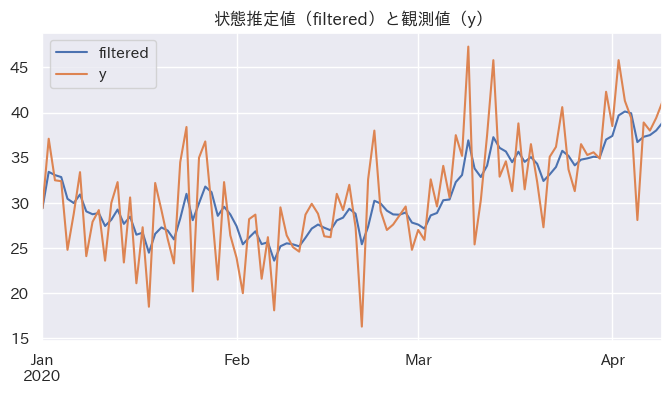

In [14]:
# Êé®ÂÆö„Åï„Çå„ÅüÁä∂ÊÖãÔºà„Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÈáèÔºâ„ÅÆÂèØË¶ñÂåñ
local_level.plot_level()

# ‚ñºË™¨Êòé
# „Åì„ÅÆÈñ¢Êï∞„Åß„ÅØ„ÄÅÊé®ÂÆö„Åï„Çå„ÅüÁä∂ÊÖãÔºàa_t: filtered stateÔºâ„Å®ÂÆüÈöõ„ÅÆË¶≥Ê∏¨ÂÄ§Ôºày_tÔºâ„Çí
# Âêå„Åò„Ç∞„É©„Éï‰∏ä„Å´Èáç„Å≠„Å¶ÊèèÁîª„Åô„Çã„ÄÇ
#
# - ÈùíÁ∑öÔºàyÔºâÔºöË¶≥Ê∏¨ÂÄ§ÔºàÂÆüÈöõ„ÅÆ„Éá„Éº„ÇøÔºâ
# - „Ç™„É¨„É≥„Ç∏Á∑öÔºàfilteredÔºâÔºö„Éï„Ç£„É´„Çø„Å´„Çà„Å£„Å¶Êé®ÂÆö„Åï„Çå„Åü„ÄåÁúü„ÅÆÁä∂ÊÖãÔºà„É¨„Éô„É´Ôºâ„Äç„ÅÆÊôÇÁ≥ªÂàó
#
# Áä∂ÊÖãÁ©∫Èñì„É¢„Éá„É´„ÅÆÊñáËÑà„Åß„ÅØ„ÄÅË¶≥Ê∏¨ÂÄ§ y_t „ÅØÊ¨°„ÅÆ„Çà„ÅÜ„Å´Ë°®„Åï„Çå„ÇãÔºö
#
#     y_t = a_t + Œµ_t
#
# ÔºàŒµ_t „ÅØË¶≥Ê∏¨Ë™§Â∑ÆÔºâ
#
# ‰∏ÄÊñπ„ÄÅÁä∂ÊÖã a_t „ÅØ‰ª•‰∏ã„ÅÆ„Çà„ÅÜ„Å´ÊôÇÁ≥ªÂàóÁöÑ„Å´Â§âÂåñ„Åô„ÇãÔºö
#
#     a_t = a_{t-1} + Œ∑_t
#
# ÔºàŒ∑_t „ÅØÈÅéÁ®ãË™§Â∑ÆÔºâ
#
# „Åì„ÅÆ„Éó„É≠„ÉÉ„Éà„ÇíÈÄö„Åó„Å¶„ÄÅ
# - Ë¶≥Ê∏¨ÂÄ§ y_t „Åå„Éé„Ç§„Ç∫„ÇíÂê´„ÇÄÂÆü„Éá„Éº„Çø„Åß„ÅÇ„Çã„ÅÆ„Å´ÂØæ„Åó„ÄÅ
# - „Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÈáè a_t „ÅØ„Åù„ÅÆËÉåÂæå„Å´„ÅÇ„ÇãÊªë„Çâ„Åã„Å™„Éà„É¨„É≥„ÉâÔºàÊΩúÂú®Áä∂ÊÖãÔºâ„ÇíË°®„Åó„Å¶„ÅÑ„Çã„Åì„Å®„ÅåÁ¢∫Ë™ç„Åß„Åç„Çã„ÄÇ
#
# „Çà„Å£„Å¶„ÄÅ„Åì„ÅÆ„Ç∞„É©„Éï„ÅØ„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÅÆÊé®ÂÆöÁµêÊûú„ÇíÁõ¥ÊÑüÁöÑ„Å´ÁêÜËß£„Åô„Çã‰∏ä„ÅßÈáçË¶Å„Åß„ÅÇ„Çã„ÄÇ

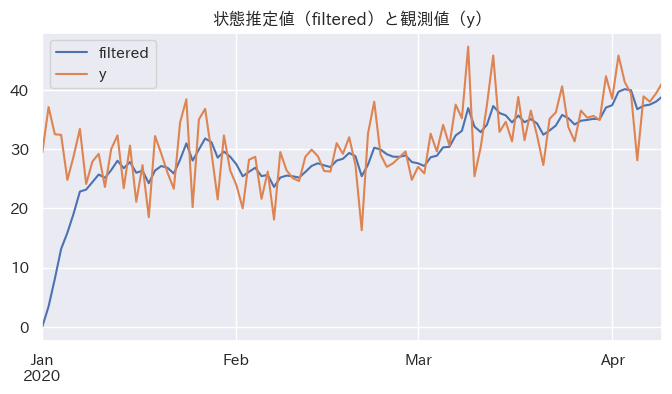

In [15]:
# ================================================
# „É≠„Éº„Ç´„É´„É¨„Éô„É´„É¢„Éá„É´ÔºàLocal Level ModelÔºâ„ÅÆÂàùÊúüÂåñ„Å®„Éï„Ç£„É´„Çø„É™„É≥„Ç∞
# ================================================

# ÂàùÊúüÁä∂ÊÖã„ÅÆË®≠ÂÆö
# initial_a : Áä∂ÊÖãÂ§âÊï∞„ÅÆÂàùÊúüÂÄ§Ôºà‰æãÔºöÊúÄÂàù„ÅÆ„É¨„Éô„É´Ôºâ
# initial_P : Áä∂ÊÖãÂàÜÊï£„ÅÆÂàùÊúüÂÄ§Ôºà‰∏çÁ¢∫ÂÆüÊÄß„ÅÆÂ§ß„Åç„ÅïÔºâ
local_level.initialize(initial_a=0, initial_P=0.01)

# „Éï„Ç£„É´„Çø„É™„É≥„Ç∞Ôºà„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÅÆÈÄêÊ¨°Êõ¥Êñ∞„ÇíË°å„ÅÜÔºâ
# s_irregular : Ë¶≥Ê∏¨Ë™§Â∑Æ„ÅÆÂàÜÊï£ œÉ_Œµ¬≤
# s_level     : Áä∂ÊÖãË™§Â∑Æ„ÅÆÂàÜÊï£ œÉ_Œ∑¬≤
# „Åì„ÅÆÂá¶ÁêÜ„Å´„Çà„Çä„ÄÅÂêÑÊôÇÁÇπ t „ÅÆ„Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÈáè a_t „Å®ÂàÜÊï£ P_t „ÅåÊõ¥Êñ∞„Åï„Çå„Çã„ÄÇ
local_level.filter(s_irregular=10, s_level=1)

# Áä∂ÊÖã„ÅÆÂèØË¶ñÂåñ
# a_tÔºà„Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÈáèÔºâ„Å®ÂÆüÈöõ„ÅÆË¶≥Ê∏¨ÂÄ§ y_t „ÇíÊØîËºÉ„Åô„Çã„ÄÇ
# „Åì„Çå„Å´„Çà„Çä„ÄÅË¶≥Ê∏¨„Éá„Éº„Çø„Å´ÂØæ„Åó„Å¶„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„Åå„Å©„ÅÆ„Çà„ÅÜ„Å´Áä∂ÊÖã„ÇíÊé®ÂÆö„Åó„Å¶„ÅÑ„Çã„Åã„ÇíÁ¢∫Ë™ç„Åß„Åç„Çã„ÄÇ
local_level.plot_level()

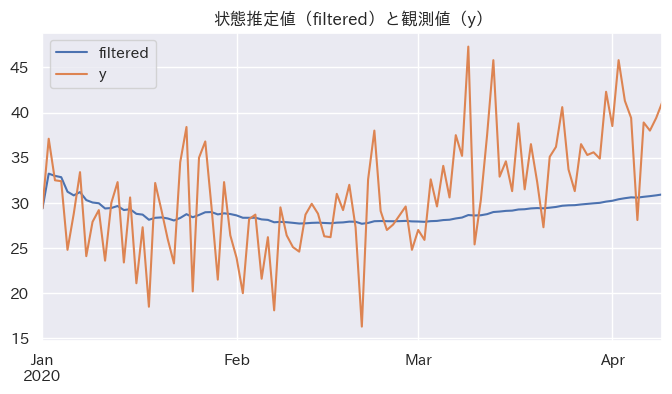

In [16]:
# ================================================
# „É≠„Éº„Ç´„É´„É¨„Éô„É´„É¢„Éá„É´ÔºàLocal Level ModelÔºâ
# Áä∂ÊÖãÁ©∫Èñì„É¢„Éá„É´„Çí„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÅßÊé®ÂÆö„Åô„Çã‰æã
# ================================================

# ------------------------------------------------
# 1. Áä∂ÊÖã„ÅÆÂàùÊúüÂåñ
# ------------------------------------------------
# initial_a : Áä∂ÊÖãÂ§âÊï∞ÔºàÁ≥ªÂàó„ÅÆÁúü„ÅÆÊ∞¥Ê∫ñÔºâ„ÅÆÂàùÊúüÂÄ§
# initial_P : Áä∂ÊÖãÂàÜÊï£ÔºàÂàùÊúü„ÅÆ‰∏çÁ¢∫ÂÆüÊÄß„ÅÆÂ§ß„Åç„ÅïÔºâ
#   ‚Üí ÂÄ§„ÅåÂ§ß„Åç„ÅÑ„Åª„Å©„ÄÅ„ÄåÊúÄÂàù„ÅØ‰Ωï„ÇÇÂàÜ„Åã„Çâ„Å™„ÅÑÔºà‰∏çÁ¢∫ÂÆüÊÄß„ÅåÈ´ò„ÅÑÔºâ„Äç„Å®‰ªÆÂÆö„Åô„Çã
local_level.initialize(initial_a=0, initial_P=1000000)

# ------------------------------------------------
# 2. „Éï„Ç£„É´„Çø„É™„É≥„Ç∞Âá¶ÁêÜÔºà„Ç´„É´„Éû„É≥„Éï„Ç£„É´„ÇøÔºâ
# ------------------------------------------------
# s_irregular : Ë¶≥Ê∏¨Ë™§Â∑Æ„ÅÆÂàÜÊï£ÔºàœÉ_Œµ¬≤Ôºâ
#   ‚Üí Ë¶≥Ê∏¨„Éé„Ç§„Ç∫„ÅÆÂ§ß„Åç„Åï„ÇíË°®„Åô„ÄÇÂÄ§„ÅåÂ§ß„Åç„ÅÑ„Åª„Å©Ë¶≥Ê∏¨ÂÄ§„ÅØ‰ø°Áî®„Åß„Åç„Å™„ÅÑ„ÄÇ
# s_level : Áä∂ÊÖãË™§Â∑Æ„ÅÆÂàÜÊï£ÔºàœÉ_Œ∑¬≤Ôºâ
#   ‚Üí Áä∂ÊÖã„ÅÆÂ§âÂãï„ÅÆÂ§ß„Åç„Åï„ÇíË°®„Åô„ÄÇÂÄ§„ÅåÂ§ß„Åç„ÅÑ„Åª„Å©Áä∂ÊÖã„ÅåÂ§âÂåñ„Åó„ÇÑ„Åô„ÅÑ„ÄÇ
#
# „Åì„ÅÆ„Çπ„ÉÜ„ÉÉ„Éó„Åß„ÅØ„ÄÅÈÄêÊ¨°ÁöÑ„Å´‰ª•‰∏ã„ÅÆÂºè„ÇíÈÅ©Áî®„Åô„ÇãÔºö
#
# ‰∫àÊ∏¨„Çπ„ÉÜ„ÉÉ„Éó:
#   a_{t|t-1} = a_{t-1|t-1}
#   P_{t|t-1} = P_{t-1|t-1} + œÉ_Œ∑¬≤
#
# „Éï„Ç£„É´„Çø„É™„É≥„Ç∞„Çπ„ÉÜ„ÉÉ„Éó:
#   v_t = y_t - a_{t|t-1}
#   K_t = P_{t|t-1} / (P_{t|t-1} + œÉ_Œµ¬≤)
#   a_{t|t} = a_{t|t-1} + K_t v_t
#   P_{t|t} = (1 - K_t) P_{t|t-1}
#
# „Åì„Çå„Å´„Çà„Çä„ÄÅÊôÇÁ≥ªÂàó„ÅÆÊΩúÂú®ÁöÑ„Å™„ÄåÁä∂ÊÖã„Äç„ÇíÂãïÁöÑ„Å´Êõ¥Êñ∞„Åó„Å¶„ÅÑ„Åè„ÄÇ
local_level.filter(s_irregular=1000, s_level=0.001)

# ------------------------------------------------
# 3. ÁµêÊûú„ÅÆÂèØË¶ñÂåñ
# ------------------------------------------------
# „Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÈáè a_tÔºàÊé®ÂÆö„Åï„Çå„ÅüÁ≥ªÂàó„ÅÆÊ∞¥Ê∫ñÔºâ„Å®ÂÆüÈöõ„ÅÆË¶≥Ê∏¨ÂÄ§ y_t „ÇíÈáç„Å≠„Å¶ÊèèÁîª„ÄÇ
# „Åì„Çå„Å´„Çà„Çä„ÄÅ„Éé„Ç§„Ç∫„ÅÆÂ§ö„ÅÑË¶≥Ê∏¨„Éá„Éº„Çø„Åã„ÇâÊªë„Çâ„Åã„Å™„Éà„É¨„É≥„Éâ„ÅåÊäΩÂá∫„Åï„Çå„Å¶„ÅÑ„Çã„Åì„Å®„ÇíÁ¢∫Ë™ç„Åß„Åç„Çã„ÄÇ
local_level.plot_level()

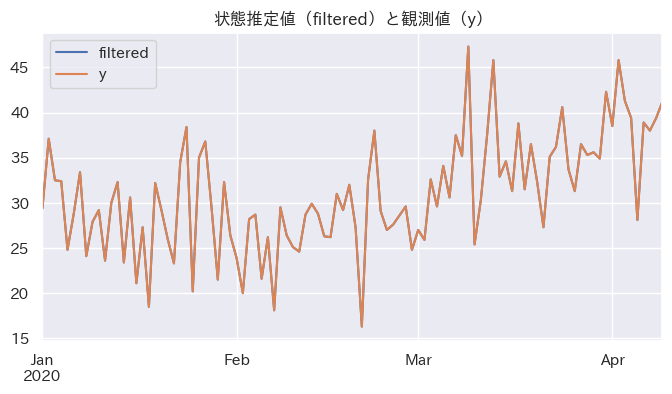

In [17]:
# ================================================
# „É≠„Éº„Ç´„É´„É¨„Éô„É´„É¢„Éá„É´ÔºàLocal Level ModelÔºâ
# Áä∂ÊÖãÁ©∫Èñì„É¢„Éá„É´„Çí„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÅßÊé®ÂÆö„Åô„Çã‰æã
# ================================================

# ------------------------------------------------
# 1. Áä∂ÊÖã„ÅÆÂàùÊúüÂåñ
# ------------------------------------------------
# initial_a : Áä∂ÊÖãÂ§âÊï∞ÔºàÁ≥ªÂàó„ÅÆÁúü„ÅÆÊ∞¥Ê∫ñÔºâ„ÅÆÂàùÊúüÂÄ§
# initial_P : Áä∂ÊÖãÂàÜÊï£ÔºàÂàùÊúü„ÅÆ‰∏çÁ¢∫ÂÆüÊÄß„ÅÆÂ§ß„Åç„ÅïÔºâ
#   ‚Üí „Åì„Åì„Åß„ÅØÈùûÂ∏∏„Å´Â§ß„Åç„ÅÑÂÄ§(1000000)„ÇíË®≠ÂÆö„Åó„ÄÅ
#      „ÄåÊúÄÂàù„ÅÆÁä∂ÊÖã„ÅØ„Åª„Å®„Çì„Å©ÂàÜ„Åã„Çâ„Å™„ÅÑÔºà‰∏çÁ¢∫ÂÆüÊÄß„ÅåÊ•µÂ§ßÔºâ„Äç„Å®‰ªÆÂÆö„Åô„Çã„ÄÇ
local_level.initialize(initial_a=0, initial_P=1000000)

# ------------------------------------------------
# 2. „Éï„Ç£„É´„Çø„É™„É≥„Ç∞Âá¶ÁêÜÔºà„Ç´„É´„Éû„É≥„Éï„Ç£„É´„ÇøÔºâ
# ------------------------------------------------
# s_irregular : Ë¶≥Ê∏¨Ë™§Â∑Æ„ÅÆÂàÜÊï£ÔºàœÉ_Œµ¬≤Ôºâ
#   ‚Üí ÈùûÂ∏∏„Å´Â∞è„Åï„ÅÑ (0.001)„ÄÇË¶≥Ê∏¨ÂÄ§„ÅØ„Åª„ÅºÊ≠£Á¢∫„Å®„Åø„Å™„Åô„ÄÇ
#
# s_level : Áä∂ÊÖãË™§Â∑Æ„ÅÆÂàÜÊï£ÔºàœÉ_Œ∑¬≤Ôºâ
#   ‚Üí ÈùûÂ∏∏„Å´Â§ß„Åç„ÅÑ (1000)„ÄÇÁä∂ÊÖã„ÅåÊøÄ„Åó„ÅèÂ§âÂåñ„Åô„Çã„É¢„Éá„É´„Çí‰ªÆÂÆö„ÄÇ
#
# „Åì„ÅÆ„Éë„É©„É°„Éº„ÇøË®≠ÂÆö„Åß„ÅØ„ÄÅ
# Ë¶≥Ê∏¨ÂÄ§ y_t „Å´ÂØæ„Åó„Å¶Áä∂ÊÖã Œ±_t „Åå„Äå„Åª„ÅºÂç≥Â∫ß„Å´ËøΩÂæì„Åô„Çã„ÄçÊåôÂãï„ÇíÁ§∫„Åô„ÄÇ
#
# Êï∞ÂºèÁöÑ„Å´„ÅØ‰ª•‰∏ã„ÅÆ„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÇíÂÜçÂ∏∞ÁöÑ„Å´ÈÅ©Áî®„Åô„ÇãÔºö
#
# ‰∫àÊ∏¨„Çπ„ÉÜ„ÉÉ„Éó:
#   a_{t|t-1} = a_{t-1|t-1}
#   P_{t|t-1} = P_{t-1|t-1} + œÉ_Œ∑¬≤
#
# „Éï„Ç£„É´„Çø„É™„É≥„Ç∞„Çπ„ÉÜ„ÉÉ„Éó:
#   v_t = y_t - a_{t|t-1}
#   K_t = P_{t|t-1} / (P_{t|t-1} + œÉ_Œµ¬≤)
#   a_{t|t} = a_{t|t-1} + K_t v_t
#   P_{t|t} = (1 - K_t) P_{t|t-1}
#
local_level.filter(s_irregular=0.001, s_level=1000)

# ------------------------------------------------
# 3. ÁµêÊûú„ÅÆÂèØË¶ñÂåñ
# ------------------------------------------------
# „Éï„Ç£„É´„ÇøÂåñ„Åï„Çå„ÅüÁä∂ÊÖã a_tÔºàÊé®ÂÆö„Åï„Çå„ÅüÁ≥ªÂàó„ÅÆÊ∞¥Ê∫ñÔºâ„Å®
# ÂÆüÈöõ„ÅÆË¶≥Ê∏¨ÂÄ§ y_t „ÇíÈáç„Å≠„Å¶„Éó„É≠„ÉÉ„Éà„Åô„Çã„ÄÇ
#
# ‰ªäÂõû„ÅØ s_level ‚â´ s_irregular „Å™„ÅÆ„Åß„ÄÅ
# Áä∂ÊÖã Œ±_t „ÅØ y_t „Å´ÈùûÂ∏∏„Å´ÊïèÊÑü„Å´ÂèçÂøú„Åó„ÄÅ„Éé„Ç§„Ç∫„Çí„Åª„Å®„Çì„Å©Âπ≥ÊªëÂåñ„Åó„Å™„ÅÑ„ÄÇ
local_level.plot_level()

In [18]:
# ÂàùÊúüÂåñ
local_level.initialize(initial_a=0, initial_P=1000000)

# „Éï„Ç£„É´„Çø„É™„É≥„Ç∞
local_level.filter(s_irregular=10, s_level=1)

# ÂØæÊï∞Â∞§Â∫¶ÔºàLog-LikelihoodÔºâ„ÅÆË®àÁÆó
# ----------------------------------------
# ÂØæÊï∞Â∞§Â∫¶„ÅØ„ÄÅ„É¢„Éá„É´„ÅåË¶≥Ê∏¨„Éá„Éº„Çø„Çí„Å©„Çå„Å†„Åë„ÅÜ„Åæ„ÅèË™¨Êòé„Åó„Å¶„ÅÑ„Çã„Åã„ÇíÁ§∫„ÅôÂ∞∫Â∫¶„Åß„ÅÇ„Çã„ÄÇ
# ÂÄ§„ÅåÂ§ß„Åç„ÅÑ„Åª„Å©„É¢„Éá„É´„ÅÆÈÅ©ÂêàÂ∫¶„ÅåÈ´ò„Åè„ÄÅÂ∞§Â∫¶ÊúÄÈÅ©Âåñ„Åß„ÅØ„Åì„ÅÆÂÄ§„ÇíÊúÄÂ§ßÂåñÔºà„Åæ„Åü„ÅØË≤†„ÅÆÂÄ§„ÇíÊúÄÂ∞èÂåñÔºâ„Åô„Çã„ÄÇ
#
# Êú¨„ÇØ„É©„Çπ„ÅÆÂÜÖÈÉ®„Åß„ÅØ„ÄÅ„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÅÆÊÆãÂ∑ÆÁ≥ªÂàó (v_t) „Å®„Åù„ÅÆÂàÜÊï£ (F_t) „ÇíÁî®„ÅÑ„Å¶‰ª•‰∏ã„ÅÆÂºè„ÅßË®àÁÆó„Åô„ÇãÔºö
#
# log L = Œ£_t log [ (1 / ‚àö(2œÄ F_t)) * exp(-v_t¬≤ / (2F_t)) ]
#
# ÂÆüË£Ö‰∏ä„ÅØ stats.norm.pdf() „Å´„Çà„ÇäÂ∞§Â∫¶„ÇíÊ±Ç„ÇÅ„ÄÅ„Åù„ÅÆÂØæÊï∞„ÇíÂèñ„Å£„Å¶ÂêàË®à„Åó„Å¶„ÅÑ„Çã„ÄÇ
# „Åì„ÅÆÁµêÊûú„ÅØ„Éë„É©„É°„Éº„ÇøÊé®ÂÆöÔºàÊúÄÂ∞§Êé®ÂÆöÔºâ„ÅÆÁ≤æÂ∫¶Ë©ï‰æ°„Å´„ÇÇÂà©Áî®„Åï„Çå„Çã„ÄÇ
local_level.llf()

-328.7964774283829

In [19]:
# „Éë„É©„É°„Éº„Çø„ÅÆÊé®ÂÆö„Å®ÂØæÊï∞Â∞§Â∫¶„ÅÆÁ¢∫Ë™ç
# ----------------------------------------

# fit() „É°„ÇΩ„ÉÉ„Éâ„Å´„Çà„Çä„ÄÅÂØæÊï∞Â∞§Â∫¶ÊúÄÂ§ßÂåñ (ÊúÄÂ§ßÂ∞§Â∫¶Êé®ÂÆö, MLE) „ÇíË°å„ÅÜ„ÄÇ
# ÂÜÖÈÉ®„Åß„ÅØ Nelder-Mead Ê≥ï„ÇíÁî®„ÅÑ„Å¶„ÄÅ‰ª•‰∏ã„ÅÆÁõÆÁöÑÈñ¢Êï∞„ÇíÊúÄÂ∞èÂåñ„Åô„ÇãÔºö
#
#     -log L = -Œ£_t log [ (1 / ‚àö(2œÄ F_t)) * exp(-v_t¬≤ / (2F_t)) ]
#
# „Éë„É©„É°„Éº„ÇøÁ©∫Èñì„ÅØÊ≠£„ÅÆÂÄ§„Å´Âà∂Á¥Ñ„Åï„Çå„Å¶„ÅÑ„Çã„Åü„ÇÅ„ÄÅ
# „É¢„Éá„É´ÂÜÖÈÉ®„Åß„ÅØ exp(Œ∏) „ÅßÂàÜÊï£„Éë„É©„É°„Éº„Çø„ÇíË°®Áèæ„Åó„Å¶„ÅÑ„Çã„ÄÇ
# ÔºàÊï∞ÂÄ§ÊúÄÈÅ©Âåñ„ÅÆÂÆâÂÆöÊÄß„ÅÆ„Åü„ÇÅÔºâ
#
# ÊúÄÁµÇÁöÑ„Å´Âæó„Çâ„Çå„Çã„Éë„É©„É°„Éº„ÇøÔºö
#   œÉ_Œµ¬≤ÔºàË¶≥Ê∏¨Ë™§Â∑Æ„ÅÆÂàÜÊï£, s_irregularÔºâ
#   œÉ_Œ∑¬≤ÔºàÁä∂ÊÖãË™§Â∑Æ„ÅÆÂàÜÊï£, s_levelÔºâ
#
# „Åì„Çå„Çâ„ÇíÂü∫„Å´„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÇíÂÜçÂÆüË°å„Åó„ÄÅÂ∞§Â∫¶„ÅÆÊúÄÂ§ßÁÇπ„ÇíÊé¢Á¥¢„Åô„Çã„ÄÇ

# „Éë„É©„É°„Éº„ÇøÊé®ÂÆö„ÅÆÂÆüË°å
local_level.fit(start_params=[1, 1])

# Êé®ÂÆöÂæå„ÅÆÂØæÊï∞Â∞§Â∫¶
# Â∞§Â∫¶„ÅåÈ´ò„ÅÑ„Åª„Å©Ôºà„Åæ„Åü„ÅØË≤†„ÅÆÂØæÊï∞Â∞§Â∫¶„ÅåÂ∞è„Åï„ÅÑ„Åª„Å©Ôºâ„ÄÅ„É¢„Éá„É´„ÅÆÈÅ©ÂêàÂ∫¶„ÅåËâØ„ÅÑ„Åì„Å®„ÇíÊÑèÂë≥„Åô„Çã„ÄÇ
local_level.llf()

-311.71335569235623

In [20]:
# ----------------------------------------
# Êé®ÂÆö„Åï„Çå„Åü„Éë„É©„É°„Éº„Çø„ÅÆÁ¢∫Ë™ç
# ----------------------------------------
# ÊúÄÂ§ßÂ∞§Â∫¶Êé®ÂÆö„Å´„Çà„Å£„Å¶Âæó„Çâ„Çå„Åü2„Å§„ÅÆÂàÜÊï£„Éë„É©„É°„Éº„Çø„ÇíË°®Á§∫„Åô„Çã„ÄÇ
# „Åì„Çå„Çâ„ÅØ„ÄÅ„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÇíÈÄö„Åò„Å¶Â∞§Â∫¶ÊúÄÂ§ßÂåñ„Å´„Çà„ÇäÊúÄÈÅ©Âåñ„Åï„Çå„ÅüÁµêÊûú„Åß„ÅÇ„Çã„ÄÇ

# œÉ_Œµ¬≤ÔºàË¶≥Ê∏¨Ë™§Â∑Æ„ÅÆÂàÜÊï£Ôºâ:
# Ë¶≥Ê∏¨„Éé„Ç§„Ç∫Ôºày_t = Œ±_t + Œµ_tÔºâ„ÅÆ„Å∞„Çâ„Å§„Åç„ÇíË°®„Åô„ÄÇ
# ÂÄ§„ÅåÂ§ß„Åç„ÅÑ„Åª„Å©„ÄÅË¶≥Ê∏¨ÂÄ§„ÅåÁúü„ÅÆÁä∂ÊÖã Œ±_t „Åã„ÇâÈõ¢„Çå„ÇÑ„Åô„ÅÑÔºà„Éé„Ç§„Ç∫„ÅåÂ§ö„ÅÑÔºâ„Åì„Å®„ÇíÊÑèÂë≥„Åô„Çã„ÄÇ

# œÉ_Œ∑¬≤ÔºàÈÅéÁ®ãË™§Â∑Æ„ÅÆÂàÜÊï£Ôºâ:
# Áä∂ÊÖã„ÅÆÂ§âÂåñÔºàŒ±_t = Œ±_{t-1} + Œ∑_tÔºâ„ÅÆ„É©„É≥„ÉÄ„É†ÊÄß„ÇíË°®„Åô„ÄÇ
# ÂÄ§„ÅåÂ§ß„Åç„ÅÑ„Åª„Å©„ÄÅ„Éà„É¨„É≥„ÉâÔºàÁä∂ÊÖãÔºâ„ÅÆÊôÇÈñìÂ§âÂåñ„ÅåÊøÄ„Åó„ÅÑ„É¢„Éá„É´„Å®„Å™„Çã„ÄÇ

print("Ë¶≥Ê∏¨Ë™§Â∑Æ„ÅÆÂàÜÊï£ œÉ_Œµ¬≤ =", np.round(local_level.s_irregular, 5))
print("ÈÅéÁ®ãË™§Â∑Æ„ÅÆÂàÜÊï£ œÉ_Œ∑¬≤ =", np.round(local_level.s_level, 5))

Ë¶≥Ê∏¨Ë™§Â∑Æ„ÅÆÂàÜÊï£ œÉ_Œµ¬≤ = 22.49697
ÈÅéÁ®ãË™§Â∑Æ„ÅÆÂàÜÊï£ œÉ_Œ∑¬≤ = 0.6952


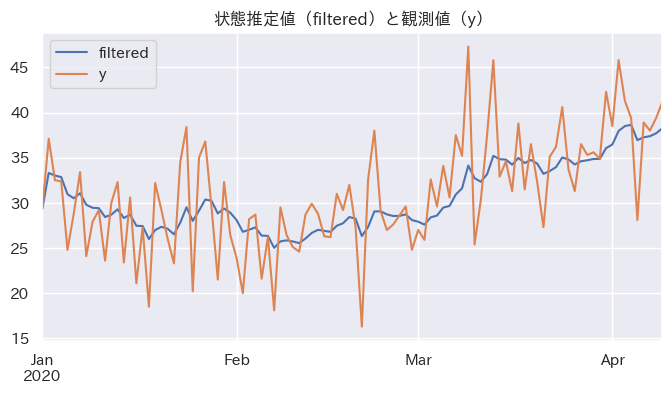

In [21]:
# ÂèÇËÄÉÔºöÊé®ÂÆö„Åï„Çå„ÅüÁä∂ÊÖã„ÅÆÂèØË¶ñÂåñ
local_level.plot_level()

In [22]:
# „Éá„Éº„Çø„ÅÆÊ†ºÁ¥ç„Å®„É¢„Éá„É´„ÅÆÁâπÂÆö
# -----------------------------------------------
# statsmodels „ÅÆ UnobservedComponents „ÇØ„É©„Çπ„ÇíÁî®„ÅÑ„Å¶„ÄÅ
# „É≠„Éº„Ç´„É´„É¨„Éô„É´„É¢„Éá„É´ÔºàLocal Level ModelÔºâ„ÇíÊåáÂÆö„Åô„Çã„ÄÇ
# - level='local level'ÔºöÁä∂ÊÖãÊñπÁ®ãÂºè„Å®„Åó„Å¶„Äå„É¨„Éô„É´„ÅÆ„Åø„Äç„ÇíÊåÅ„Å§„É¢„Éá„É´„ÇíÂÆöÁæ©
# - loglikelihood_burn=0ÔºöÂàùÊúü„Çµ„É≥„Éó„É´„ÅÆÈô§Â§ñÊï∞„Çí0„Å´Ë®≠ÂÆöÔºàÂÖ®„Éá„Éº„Çø„ÇíÂ∞§Â∫¶Ë®àÁÆó„Å´‰ΩøÁî®Ôºâ
# -----------------------------------------------
mod_local_level_fix = tsa.UnobservedComponents(
    y_ts,  # ÂØæË±°„ÅÆÊôÇÁ≥ªÂàó„Éá„Éº„ÇøÔºàpd.SeriesÔºâ
    level="local level",  # „É¢„Éá„É´ÊßãÈÄ†Ôºö„É≠„Éº„Ç´„É´„É¨„Éô„É´„É¢„Éá„É´
    loglikelihood_burn=0,  # Â∞§Â∫¶Ë®àÁÆóÊôÇ„Å´Èô§Â§ñ„Åô„ÇãÂàùÊúü„Çµ„É≥„Éó„É´Êï∞
)

In [23]:
# ÂàùÊúüÂåñ
# -----------------------------------------------
# Áä∂ÊÖãÁ©∫Èñì„É¢„Éá„É´„ÅÆÂàùÊúüÁä∂ÊÖã„Çí„ÄåÊã°Êï£ÁöÑÂàùÊúüÂåñ (Diffuse Initialization)„Äç„ÅßË®≠ÂÆö„Åô„Çã„ÄÇ
# „Åì„Çå„ÅØ„ÄÅÂàùÊúü„ÅÆ‰∏çÁ¢∫ÂÆüÊÄßÔºàÂàÜÊï£Ôºâ„ÇíÈùûÂ∏∏„Å´Â§ß„Åç„ÅèË®≠ÂÆö„Åô„Çã„Åì„Å®„Åß„ÄÅ
# „É¢„Éá„É´„ÅåÂçÅÂàÜ„Å´„Éá„Éº„Çø„ÇíË¶≥Ê∏¨„Åó„ÅüÂæå„Å´„ÄÅÁä∂ÊÖã„Çí„Éá„Éº„ÇøÈßÜÂãïÁöÑ„Å´Êé®ÂÆö„Åß„Åç„Çã„Çà„ÅÜ„Å´„Åô„Çã„Åü„ÇÅ„ÅÆÊñπÊ≥ï„Åß„ÅÇ„Çã„ÄÇ
#
# „Éªinitialize_approximate_diffuse(1000000)
#     ‚Üí ÂàùÊúü„ÅÆÂàÜÊï£ P‚ÇÄ „Çí 1,000,000ÔºàÈùûÂ∏∏„Å´Â§ß„Åç„ÅÑÂÄ§Ôºâ„Å®„Åó„Å¶Ë®≠ÂÆö
#     ‚Üí Áä∂ÊÖã„ÅÆÂàùÊúüÂÄ§ a‚ÇÄ „ÅØÊó¢ÂÆö„Åß0„Å®„Å™„ÇãÔºàÂøÖË¶Å„Å´Âøú„Åò„Å¶Âà•ÈÄîÊåáÂÆöÂèØËÉΩÔºâ
#
# „Åì„ÅÆÊâãÊ≥ï„ÅØ„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„Å´„Åä„Åë„Çã„ÄåÈùûÊÉÖÂ†±ÁöÑ‰∫ãÂâçÂàÜÂ∏ÉÔºànon-informative priorÔºâ„Äç„Å´Áõ∏ÂΩì„Åó„ÄÅ
# Áâπ„Å´„Éà„É¨„É≥„ÉâÊàêÂàÜ„ÅåÂº∑„ÅÑ„É¢„Éá„É´Ôºà‰æãÔºö„É≠„Éº„Ç´„É´„É¨„Éô„É´„É¢„Éá„É´„Å™„Å©Ôºâ„ÅßÂÆâÂÆö„Åó„ÅüÊé®ÂÆö„ÇíÂæó„Çã„Åü„ÇÅ„Å´Áî®„ÅÑ„Çâ„Çå„Çã„ÄÇ
# -----------------------------------------------

mod_local_level_fix.initialize_approximate_diffuse(1000000)

In [24]:
# „Éï„Ç£„É´„Çø„É™„É≥„Ç∞
# -----------------------------------------------
# „É¢„Éá„É´„ÇíÂõ∫ÂÆö„Éë„É©„É°„Éº„ÇøÔºà„Åì„Åì„Åß„ÅØË¶≥Ê∏¨Ë™§Â∑ÆÂàÜÊï£Ôºù10, ÈÅéÁ®ãË™§Â∑ÆÂàÜÊï£Ôºù1Ôºâ„Åß„Éï„Ç£„É´„Çø„É™„É≥„Ç∞„Åô„Çã„ÄÇ
# „Åì„Çå„ÅØ„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÅÆ„ÄåÂâçÂêë„ÅçÊé®ÂÆö„Çπ„ÉÜ„ÉÉ„Éó„Äç„Å´Áõ∏ÂΩì„Åó„ÄÅ
# ÂêÑÊôÇÁÇπ„ÅßÁä∂ÊÖã„ÅÆÊúÄÈÅ©Êé®ÂÆöÂÄ§Ôºàa_t|tÔºâ„Å®„Åù„ÅÆÂàÜÊï£ÔºàP_t|tÔºâ„ÇíÂÜçÂ∏∞ÁöÑ„Å´Êõ¥Êñ∞„Åó„Å¶„ÅÑ„Åè„ÄÇ
#
# ÂºïÊï∞Ôºö
#   pd.Series(np.array([10, 1])) ‚Üí
#       1„Å§ÁõÆÔºöË¶≥Ê∏¨Ë™§Â∑ÆÂàÜÊï£ œÉ_Œµ¬≤ = 10
#       2„Å§ÁõÆÔºöÈÅéÁ®ãË™§Â∑ÆÂàÜÊï£ œÉ_Œ∑¬≤ = 1
#
# Âá∫ÂäõÔºö
#   res_local_level_fix ‚Üí Áä∂ÊÖãÁ©∫Èñì„É¢„Éá„É´ÔºàUnobservedComponentsÔºâ„ÅÆ„Éï„Ç£„É´„Çø„É™„É≥„Ç∞ÁµêÊûú„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà
#       „Éªres_local_level_fix.filtered_state : ÂêÑÊôÇÁÇπ„ÅÆ„Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÂÄ§
#       „Éªres_local_level_fix.smoothed_state : „Çπ„É†„Éº„Ç∏„É≥„Ç∞Âæå„ÅÆÊé®ÂÆöÂÄ§ÔºàÂæåÂêë„ÅçÊõ¥Êñ∞„ÇíÂê´„ÇÄÂ†¥ÂêàÔºâ
#       „Éªres_local_level_fix.llf : ÂØæÊï∞Â∞§Â∫¶ÂÄ§
# -----------------------------------------------

res_local_level_fix = mod_local_level_fix.filter(pd.Series(np.array([10, 1])))

In [25]:
# „Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÈáè„ÅÆÂèñ„ÇäÂá∫„Åó
# -----------------------------------------------
# res_local_level_fix.level["filtered"] „ÅØ„ÄÅ
# ÂêÑÊôÇÁÇπ„Å´„Åä„Åë„Çã„ÄåÁä∂ÊÖãÔºà„É¨„Éô„É´ Œ±_tÔºâ„Äç„ÅÆ„Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÂÄ§ a_{t|t} „ÇíË°®„Åô„ÄÇ
#
# „Åì„Åì„Åß np.round(..., 5) „Å´„Çà„Çä„ÄÅÂ∞èÊï∞ÁÇπ‰ª•‰∏ã5Ê°Å„Å´‰∏∏„ÇÅ„Å¶Âá∫Âäõ„Åô„Çã„ÄÇ
# ÂÖàÈ†≠3‰ª∂„ÅÆ„Åø„ÇíÁ¢∫Ë™ç„Åô„Çã„Åì„Å®„Åß„ÄÅ„Éï„Ç£„É´„Çø„É™„É≥„Ç∞„ÅÆÊåôÂãï„ÇíÁ∞°Âçò„Å´Á¢∫Ë™ç„Åß„Åç„Çã„ÄÇ
#
# Êï∞ÂºèÁöÑ„Å´„ÅØ‰ª•‰∏ã„ÅÆÊõ¥Êñ∞Âºè„ÅßÂæó„Çâ„Çå„ÇãÔºö
#   a_{t|t} = a_{t|t-1} + K_t (y_t - a_{t|t-1})
#   ÔºàK_tÔºö„Ç´„É´„Éû„É≥„Ç≤„Ç§„É≥Ôºâ
# -----------------------------------------------

np.round(res_local_level_fix.level["filtered"][0:3], 5)

array([29.39971, 33.43318, 33.07468])

In [26]:
# ÂØæÊï∞Â∞§Â∫¶„ÅÆÂèñ„ÇäÂá∫„Åó
# -----------------------------------------------
# res_local_level_fix.llf „ÅØ„ÄÅ„É≠„Éº„Ç´„É´„É¨„Éô„É´„É¢„Éá„É´„Å´„Åä„Åë„Çã
# Â∞§Â∫¶ÔºàlikelihoodÔºâ„ÅÆÂØæÊï∞ÂÄ§ log L „ÇíË°®„Åô„ÄÇ
#
# ÂØæÊï∞Â∞§Â∫¶„ÅØÊ¨°„ÅÆÂºè„ÅßÂÆöÁæ©„Åï„Çå„ÇãÔºö
#   log L = Œ£_t log [ (1 / ‚àö(2œÄF_t)) * exp(‚àív_t¬≤ / (2F_t)) ]
#
# „Åì„Åì„ÅßÔºö
#   v_tÔºöË¶≥Ê∏¨ÂÄ§„ÅÆ1ÊôÇÁÇπÂÖà‰∫àÊ∏¨Ë™§Â∑ÆÔºày_t ‚àí a_{t|t‚àí1}Ôºâ
#   F_tÔºö„Åù„ÅÆË™§Â∑Æ„ÅÆÂàÜÊï£ÔºàP_{t|t‚àí1} + œÉ_Œµ¬≤Ôºâ
#
# ÂÄ§„ÅåÂ§ß„Åç„ÅÑ„Åª„Å©Ôºà„Çà„Çä 0 „Å´Ëøë„ÅÑ„Åª„Å©Ôºâ„É¢„Éá„É´„ÅÆÂΩì„Å¶„ÅØ„Åæ„Çä„ÅåËâØ„ÅÑ„Åì„Å®„ÇíÊÑèÂë≥„Åô„Çã„ÄÇ
# -----------------------------------------------

np.round(res_local_level_fix.llf, 5)

-328.79648

In [27]:
# ÂèÇËÄÉÔºöÊé®ÂÆöÁµêÊûú„ÅÆË¶ÅÁ¥Ñ„ÇíË°®Á§∫
# -----------------------------------------------
# summary() „É°„ÇΩ„ÉÉ„Éâ„ÅØ„ÄÅÁä∂ÊÖãÁ©∫Èñì„É¢„Éá„É´Ôºà„Åì„Åì„Åß„ÅØ„É≠„Éº„Ç´„É´„É¨„Éô„É´„É¢„Éá„É´Ôºâ„ÅÆ
# „Éë„É©„É°„Éº„ÇøÊé®ÂÆöÁµêÊûú„ÇÑÂ∞§Â∫¶Áµ±Ë®àÈáè„Å™„Å©„ÇíÊï¥ÂΩ¢„Åó„Å¶Âá∫Âäõ„Åô„Çã„ÄÇ
#
# Âá∫Âäõ„Å´„ÅØ‰ª•‰∏ã„ÅåÂê´„Åæ„Çå„ÇãÔºö
#   - Model: ‰ΩøÁî®„Åó„Åü„É¢„Éá„É´„ÅÆÊßãÈÄ†Ôºà‰æãÔºöLocal LevelÔºâ
#   - Log Likelihood: ÂØæÊï∞Â∞§Â∫¶Ôºà„É¢„Éá„É´„ÅÆÂΩì„Å¶„ÅØ„Åæ„Çä„ÅÆËâØ„ÅïÔºâ
#   - AIC / BIC: „É¢„Éá„É´ÊØîËºÉ„ÅÆ„Åü„ÇÅ„ÅÆÊÉÖÂ†±ÈáèÂü∫Ê∫ñ
#   - Ë®≠ÂÆö„Åï„Çå„ÅüÂàÜÊï£„Éë„É©„É°„Éº„ÇøÔºàœÉ_Œµ¬≤, œÉ_Œ∑¬≤ „Å™„Å©Ôºâ
#   - Âπ≥ÊªëÂåñ„Éª„Éï„Ç£„É´„ÇøÂåñÊ∏à„Åø„ÅÆÁä∂ÊÖãÊé®ÂÆöÁµ±Ë®àÈáè
#
# „Åì„ÅÆÁµêÊûú„Å´„Çà„Çä„ÄÅË¶≥Ê∏¨„Éé„Ç§„Ç∫„Å®Áä∂ÊÖã„Éé„Ç§„Ç∫„ÅÆÂØÑ‰∏é„ÇíÊØîËºÉ„Åó„ÄÅ
# „É¢„Éá„É´„ÅÆÂ¶•ÂΩìÊÄß„ÇíÁ¢∫Ë™ç„Åß„Åç„Çã„ÄÇ
# -----------------------------------------------

print(res_local_level_fix.summary())

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                -328.796
Date:                Thu, 16 Oct 2025   AIC                            661.593
Time:                        21:34:30   BIC                            666.803
Sample:                    01-01-2020   HQIC                           663.702
                         - 04-09-2020                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    10.0000      0.747     13.381      0.000       8.535      11.465
sigma2.level         1.0000      0.257      3.891      0.000       0.496       1.504
Ljung-Box (L1) (Q):         

In [29]:
# üìò „É≠„Éº„Ç´„É´„É¨„Éô„É´„É¢„Éá„É´ÔºàLocal Level ModelÔºâ„ÅÆÊúÄÂ∞§Êé®ÂÆö„Å´„Çà„ÇãÊé®ÂÆöÂá¶ÁêÜ
# =====================================================================

# 1Ô∏è‚É£ „Éá„Éº„Çø„ÅÆÊ†ºÁ¥ç„Å®„É¢„Éá„É´ÊßãÈÄ†„ÅÆÁâπÂÆö
# UnobservedComponentsÔºàÁä∂ÊÖãÁ©∫Èñì„É¢„Éá„É´Ôºâ„ÇíÁî®„ÅÑ„ÄÅ
# „Äå„É≠„Éº„Ç´„É´„É¨„Éô„É´Ôºàlocal levelÔºâ„Äç„É¢„Éá„É´„ÇíÊßãÁØâ„Åô„Çã„ÄÇ
mod_local_level = tsa.UnobservedComponents(
    y_ts, level="local level", loglikelihood_burn=0
)

# 2Ô∏è‚É£ ÂàùÊúüÂåñ
# diffuseÔºàÈùûÊÉÖÂ†±ÁöÑÔºâ‰∫ãÂâçÂàÜÂ∏É„Çí‰ªÆÂÆö„Åó„Å¶ÂàùÊúüÂåñ„ÄÇ
# Êï∞ÂÄ§„ÇíÂ§ß„Åç„ÅèÔºà‰æãÔºö1e6ÔºâË®≠ÂÆö„Åô„Çã„Åì„Å®„Åß„ÄÅÂàùÊúüÂÄ§„Å´‰æùÂ≠ò„Åó„Å™„ÅÑ„Çà„ÅÜ„Å´„Åô„Çã„ÄÇ
mod_local_level.initialize_approximate_diffuse(1000000)

# 3Ô∏è‚É£ „Éï„Ç£„É´„Çø„É™„É≥„Ç∞„Å®ÊúÄÂ∞§Ê≥ï„Å´„Çà„Çã„Éë„É©„É°„Éº„ÇøÊé®ÂÆö
# Nelder‚ÄìMeadÊ≥ï„ÇíÁî®„ÅÑ„Å¶„ÄÅË¶≥Ê∏¨Ë™§Â∑Æ„Å®Áä∂ÊÖãË™§Â∑Æ„ÅÆÂàÜÊï£„ÇíÊúÄÂ∞§Êé®ÂÆö„Åô„Çã„ÄÇ
res_local_level = mod_local_level.fit(
    start_params=[1, 1],  # ÂàùÊúüÊé®ÂÆöÂÄ§Ôºàlog„Çπ„Ç±„Éº„É´„Åß„ÅØ„Å™„ÅÑÔºâ
    method="nm",  # Nelder‚ÄìMeadÊ≥ï
    maxiter=2000,  # ÂèçÂæ©‰∏äÈôê
)

# 4Ô∏è‚É£ Êé®ÂÆöÁµêÊûú„ÅÆÊ¶ÇË¶Å„ÇíË°®Á§∫
# Âá∫ÂäõÂÜÖÂÆπ„Å´„ÅØ‰ª•‰∏ã„ÅåÂê´„Åæ„Çå„ÇãÔºö
#   - Ë¶≥Ê∏¨Ë™§Â∑ÆÂàÜÊï£ (œÉ_Œµ¬≤)
#   - Áä∂ÊÖãË™§Â∑ÆÂàÜÊï£ (œÉ_Œ∑¬≤)
#   - ÂØæÊï∞Â∞§Â∫¶ (Log-Likelihood)
#   - ÊÉÖÂ†±ÈáèÂü∫Ê∫ñ (AIC, BIC)
#   - Áä∂ÊÖãÊé®ÂÆöÁµ±Ë®àÔºàlevel„ÅÆfilteredÂÄ§„Å™„Å©Ôºâ
print(res_local_level.summary())

Optimization terminated successfully.
         Current function value: 3.117134
         Iterations: 48
         Function evaluations: 92
                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                -311.713
Date:                Thu, 16 Oct 2025   AIC                            627.427
Time:                        21:35:16   BIC                            632.637
Sample:                    01-01-2020   HQIC                           629.535
                         - 04-09-2020                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    22.4973      3.659      6.149      0.000

In [30]:
# üìò GitHub„É¨„Éì„É•„Éº„Ç≥„É°„É≥„Éà

# ‚úÖ Ê§úË®ºÂÜÖÂÆπ
# Ëá™‰Ωú„ÅÆ„Ç´„É´„Éû„É≥„Éï„Ç£„É´„ÇøÔºàLocalLevel„ÇØ„É©„ÇπÔºâ„ÅßÊé®ÂÆö„Åï„Çå„Åü
# Áä∂ÊÖãÊé®ÂÆöÂÄ§ `a_t` „Åå„ÄÅ`statsmodels` „ÅÆ `UnobservedComponents`
# „Å´„Çà„Çã„É≠„Éº„Ç´„É´„É¨„Éô„É´„É¢„Éá„É´Êé®ÂÆöÁµêÊûúÔºàfiltered stateÔºâ„Å®
# ‰∏ÄËá¥„Åó„Å¶„ÅÑ„Çã„Åã„ÇíÊï∞ÂÄ§ÁöÑ„Å´Á¢∫Ë™ç„Åó„Å¶„ÅÑ„Çã„ÄÇ

# ‚úÖ „Ç≥„Éº„Éâ
np.sum((local_level.a - res_local_level.level["filtered"]) ** 2)

# ‚úÖ ÁµêÊûú„ÅÆËß£Èáà
# Ë®àÁÆóÁµêÊûú„ÅØ **„Åª„Åº„Çº„É≠** „Å´Ëøë„ÅÑÂÄ§„Å®„Å™„Çã„ÄÇ
# „Åì„Çå„ÅØ„ÄÅÁã¨Ëá™ÂÆüË£Ö„Åó„Åü„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„ÅÆÊõ¥Êñ∞ÂºèÔºö

#   a_{t|t} = a_{t|t-1} + K_t v_t
#   P_{t|t} = (1 - K_t) P_{t|t-1}

# „Åå„ÄÅ`statsmodels` „Å´„Åä„Åë„ÇãÁä∂ÊÖãÁ©∫ÈñìË°®Áèæ„Å®‰∏ÄËá¥„Åó„Å¶„ÅÑ„Çã„Åì„Å®„ÇíÁ§∫„Åô„ÄÇ
# „Çà„Å£„Å¶„ÄÅËá™‰Ωú„ÇØ„É©„Çπ `LocalLevel` „ÅÆ„Éï„Ç£„É´„Çø„É™„É≥„Ç∞Âá¶ÁêÜ„ÅØ
# Ê≠£„Åó„ÅèÂÆüË£Ö„Åï„Çå„Å¶„ÅÑ„Çã„Å®Âà§Êñ≠„Åß„Åç„Çã„ÄÇ

4.3155904268713204e-08

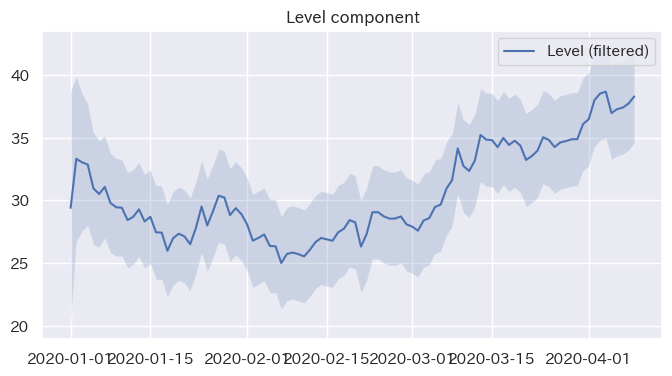

In [31]:
# üìò GitHub„É¨„Éì„É•„Éº„Ç≥„É°„É≥„Éà

# ‚úÖ Ê¶ÇË¶Å
# `tsa.UnobservedComponents` „Å´„Çà„Çã„É≠„Éº„Ç´„É´„É¨„Éô„É´„É¢„Éá„É´„ÅÆ„Éï„Ç£„É´„ÇøÂåñÁµêÊûú„Çí
# ÂèØË¶ñÂåñ„Åô„ÇãÂá¶ÁêÜ„ÄÇ`plot_components()` „ÅØÂêÑÊôÇÁÇπ„Åß„ÅÆ
# „Äå„Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÂÄ§„Äç„ÇÑ„Äå„Éà„É¨„É≥„ÉâÊàêÂàÜ„Äç„Å™„Å©„Çí„Éó„É≠„ÉÉ„Éà„Åô„ÇãÈñ¢Êï∞„Åß„ÅÇ„Çã„ÄÇ

# ‚úÖ „Ç≥„Éº„Éâ
_ = res_local_level.plot_components(which="filtered", observed=False)

# ‚úÖ Ë£úË∂≥
# - `which="filtered"`Ôºö„Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„Å´„Çà„Å£„Å¶Êé®ÂÆö„Åï„Çå„ÅüÁä∂ÊÖãÊàêÂàÜÔºàa_{t|t}Ôºâ„ÇíÂèØË¶ñÂåñ„ÄÇ
# - `observed=False` ÔºöË¶≥Ê∏¨„Éá„Éº„ÇøÔºày_tÔºâ„ÅØË°®Á§∫„Åõ„Åö„ÄÅÁä∂ÊÖãÊé®ÂÆöÂÄ§„ÅÆ„Åø„ÇíÊèèÁîª„ÄÇ
# - Âá∫Âäõ„Åï„Çå„Çã„Ç∞„É©„Éï„Åß„ÅØ„ÄÅÊôÇÈñì„Å®„Å®„ÇÇ„Å´Âπ≥ÊªëÂåñ„Åï„Çå„Åü„Éà„É¨„É≥„Éâ„ÅåÁ¢∫Ë™ç„Åß„Åç„Çã„ÄÇ

# ‚úÖ „Ç≥„É°„É≥„Éà
# Áä∂ÊÖãÁ©∫Èñì„É¢„Éá„É´„ÅÆ„Éï„Ç£„É´„Çø„É™„É≥„Ç∞ÁµêÊûú„ÇíË¶ñË¶öÁöÑ„Å´Á¢∫Ë™ç„Åô„Çã„Åì„Å®„Åß„ÄÅ
# „Ç´„É´„Éû„É≥„Éï„Ç£„É´„Çø„Åå„Éé„Ç§„Ç∫„ÅÆÂ§ö„ÅÑË¶≥Ê∏¨ÂÄ§„Åã„ÇâÊªë„Çâ„Åã„Å™„É¨„Éô„É´Êé®ÂÆö„Çí
# „Å©„ÅÆ„Çà„ÅÜ„Å´Ë°å„Å£„Å¶„ÅÑ„Çã„Åã„ÅåÁõ¥ÊÑüÁöÑ„Å´ÁêÜËß£„Åß„Åç„Çã„ÄÇ
# „Å®„Åè„Å´„Äå„É≠„Éº„Ç´„É´„É¨„Éô„É´„É¢„Éá„É´„Äç„Åß„ÅØ„ÄÅ„Éà„É¨„É≥„Éâ„ÅÆÂ§âÂåñÁÇπ„ÇÑ
# Èï∑ÊúüÁöÑÂÇæÂêë„ÇíË¶ñË¶öÁöÑ„Å´Êçâ„Åà„Çã„ÅÆ„Å´ÊúâÂäπ„Åß„ÅÇ„Çã„ÄÇ

In [32]:
# üìò GitHub„É¨„Éì„É•„Éº„Ç≥„É°„É≥„Éà

# ‚úÖ Ê¶ÇË¶Å
# `res_local_level.level["smoothed"]` „ÅØ„ÄÅ„Ç´„É´„Éû„É≥Âπ≥ÊªëÂåñÔºàKalman SmootherÔºâ„Å´„Çà„Å£„Å¶
# Âæó„Çâ„Çå„Åü„ÄåÂπ≥ÊªëÂåñÊé®ÂÆöÈáè (a_{t|T})„Äç„ÇíÂèñ„ÇäÂá∫„ÅôÂá¶ÁêÜ„Åß„ÅÇ„Çã„ÄÇ
# „Åì„Çå„ÅØ„ÄÅÂÖ®Ë¶≥Ê∏¨„Éá„Éº„ÇøÔºàt=1ÔΩûTÔºâ„ÇíÁî®„ÅÑ„Åü„Äå‰∫ãÂæåÊé®ÂÆö„Äç„Åß„ÅÇ„Çä„ÄÅ
# ÂêÑÊôÇÁÇπ„ÅÆÁä∂ÊÖã„ÇíÊúÄ„ÇÇÁ≤æÂØÜ„Å´Êé®ÂÆö„Åó„ÅüÂÄ§„ÇíË°®„Åô„ÄÇ

# ‚úÖ „Ç≥„Éº„Éâ
np.round(res_local_level.level["smoothed"][0:3], 5)

# ‚úÖ Êï∞ÂºèÔºàÂπ≥ÊªëÂåñ„ÅÆÂÜçÂ∏∞ÂºèÔºâ
# „Éï„Ç£„É´„Çø„É™„É≥„Ç∞Ôºàa_{t|t}Ôºâ„ÅÆÂæå„Å´„ÄÅÂæå„ÇçÂêë„Åç„Å´ÂÜçÂ∏∞„Åó„Å¶Âπ≥ÊªëÂåñ„ÇíË°å„ÅÜÔºö
# $$
# \begin{aligned}
# r_{t-1} &= K_t' (v_t / F_t) + L_t' r_t \\
# a_{t|T} &= a_{t|t} + P_{t|t} r_{t-1}
# \end{aligned}
# $$
# „Åì„Åì„Åß„ÄÅ
# - \( a_{t|T} \)ÔºöÊôÇÁÇπt„ÅÆÂπ≥ÊªëÂåñÊé®ÂÆöÈáèÔºàÂÖ®„Éá„Éº„Çø„ÇíËÄÉÊÖÆ„Åó„ÅüÁä∂ÊÖãÊé®ÂÆöÂÄ§Ôºâ
# - \( K_t \)Ôºö„Ç´„É´„Éû„É≥„Ç≤„Ç§„É≥
# - \( L_t = I - K_t Z_t \)Ôºö„Éï„Ç£„É´„ÇøÊõ¥Êñ∞Âæå„ÅÆÂ§âÊèõË°åÂàó
# - \( r_t \)Ôºö„Çπ„É†„Éº„Ç∏„É≥„Ç∞„Ç≤„Ç§„É≥„ÅÆÂÜçÂ∏∞È†Ö

# ‚úÖ „Ç≥„É°„É≥„Éà
# „Éï„Ç£„É´„ÇøÂåñÊé®ÂÆöÈáè \( a_{t|t} \) „ÅØ„ÄåÈÄêÊ¨°Êõ¥Êñ∞„Äç„Å´Âü∫„Å•„Åè„Ç™„É≥„É©„Ç§„É≥Êé®ÂÆö„Åß„ÅÇ„Çã„ÅÆ„Å´ÂØæ„Åó„ÄÅ
# Âπ≥ÊªëÂåñÊé®ÂÆöÈáè \( a_{t|T} \) „ÅØ„ÄåÂÖ®ÊúüÈñì„ÅÆÊÉÖÂ†±„Äç„ÇíÂà©Áî®„Åó„Å¶‰∫ãÂæåÁöÑ„Å´Êé®ÂÆö„Åï„Çå„Çã„Åü„ÇÅ„ÄÅ
# „Çà„ÇäÊªë„Çâ„Åã„ÅßÂÆâÂÆö„Åó„Åü„Éà„É¨„É≥„Éâ„ÅåÂæó„Çâ„Çå„Çã„ÄÇ
# Áä∂ÊÖãÁ©∫Èñì„É¢„Éá„É´„ÅÆÂàÜÊûê„Å´„Åä„ÅÑ„Å¶„ÄÅ„Éà„É¨„É≥„ÉâÊäΩÂá∫„ÇÑ‰∫ãÂæåÊé®ÂÆö„Å´ÊúÄ„ÇÇÈáçË¶Å„Å™„Çπ„ÉÜ„ÉÉ„Éó„Åß„ÅÇ„Çã„ÄÇ

array([30.19488, 30.21947, 30.03142])

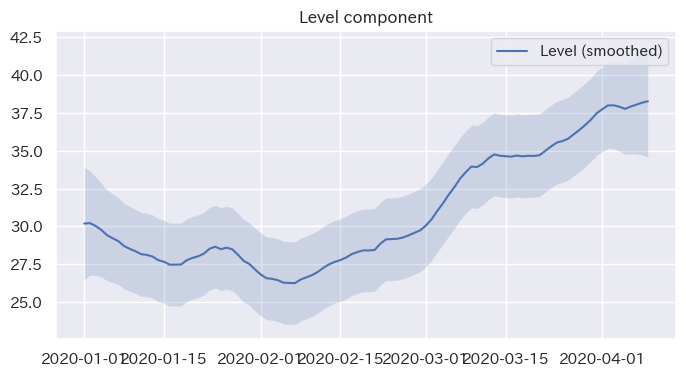

In [33]:
# üìò GitHub„É¨„Éì„É•„Éº„Ç≥„É°„É≥„Éà

# ‚úÖ Ê¶ÇË¶Å
# „ÄåÂπ≥ÊªëÂåñÊé®ÂÆöÈáèÔºàSmoothed EstimatesÔºâ„Äç„ÅÆÂèØË¶ñÂåñ„ÇíË°å„ÅÜ„ÄÇ
# „Åì„Çå„ÅØÂÖ®ÊúüÈñì„ÅÆÊÉÖÂ†±Ôºàt=1„ÄúTÔºâ„ÇíÁî®„ÅÑ„Å¶„ÄÅÂêÑÊôÇÁÇπ„ÅÆÁä∂ÊÖã„Çí
# ÊúÄ„ÇÇÁ≤æÂ∫¶È´ò„ÅèÊé®ÂÆö„Åó„ÅüÁµêÊûú„ÇíÂõ≥Á§∫„Åô„Çã„Çπ„ÉÜ„ÉÉ„Éó„Åß„ÅÇ„Çã„ÄÇ

# ‚úÖ „Ç≥„Éº„Éâ
_ = res_local_level.plot_components(which="smoothed", observed=False)

# ‚úÖ Êï∞Âºè
# Âπ≥ÊªëÂåñ„ÅØ„ÄÅ„Éï„Ç£„É´„Çø„É™„É≥„Ç∞ÁµêÊûú (a_{t|t}, P_{t|t}) „ÇíÂü∫„Å´Âæå„ÇçÂêë„Åç„Å´ÂÜçÂ∏∞„Åó„Å¶Ë®àÁÆó„Åï„Çå„Çã„ÄÇ
# $$
# \begin{aligned}
# r_{t-1} &= K_t' \frac{v_t}{F_t} + L_t' r_t \\
# a_{t|T} &= a_{t|t} + P_{t|t} r_{t-1} \\
# P_{t|T} &= P_{t|t} - P_{t|t} L_t' (P_{t+1|T}^{-1} - P_{t+1|t}^{-1}) L_t P_{t|t}
# \end{aligned}
# $$
# „Åì„Åì„ÅßÔºö
# - \( a_{t|T} \)ÔºöÊôÇÁÇπt„ÅÆÂπ≥ÊªëÂåñÊé®ÂÆöÈáè
# - \( P_{t|T} \)Ôºö„Åù„ÅÆÂàÜÊï£Ôºà‰∏çÁ¢∫ÂÆüÊÄß„ÅÆÂ∞è„Åï„ÅÑÂæåÂá¶ÁêÜÂÄ§Ôºâ
# - \( r_t \)Ôºö„Çπ„É†„Éº„Ç∏„É≥„Ç∞„Ç≤„Ç§„É≥ÂÜçÂ∏∞È†Ö
# - \( L_t = I - K_t Z_t \)ÔºöÊõ¥Êñ∞Âæå„ÅÆÂ§âÊèõË°åÂàó

# ‚úÖ „Ç≥„É°„É≥„Éà
# „Éï„Ç£„É´„ÇøÂåñÔºà„Ç™„É≥„É©„Ç§„É≥ÔºâÊé®ÂÆö„ÅØ„ÄåÈÄêÊ¨°ÁöÑ„Äç„Å´Êõ¥Êñ∞„Åï„Çå„Çã„ÅÆ„Å´ÂØæ„Åó„ÄÅ
# Âπ≥ÊªëÂåñÔºà„Ç™„Éï„É©„Ç§„É≥ÔºâÊé®ÂÆö„ÅØ„ÄåÂÖ®„Éá„Éº„Çø„Äç„Çí‰Ωø„Å£„Å¶Âæå„ÇçÂêë„Åç„Å´Êé®ÂÆö„Åï„Çå„Çã„ÄÇ
# „Åù„ÅÆ„Åü„ÇÅ„Éé„Ç§„Ç∫„Å´Âº∑„Åè„ÄÅ„Çà„ÇäÊªë„Çâ„Åã„Å™„Éà„É¨„É≥„Éâ„ÅåÂæó„Çâ„Çå„Çã„ÄÇ
# „Åì„ÅÆ„Éó„É≠„ÉÉ„Éà„Åß„ÅØ„ÄÅË¶≥Ê∏¨„Éá„Éº„Çø„ÅÆËÉåÂæå„Å´„ÅÇ„Çã„ÄåÁúü„ÅÆÁä∂ÊÖãÁ≥ªÂàóÔºàlevelÔºâ„Äç„ÇíÂèØË¶ñÂåñ„Åß„Åç„Çã„ÄÇ